<a href="https://colab.research.google.com/github/Shashank-4321/Dynamic-pricing-engine/blob/main/Dynamic_pricing_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Generation synthetic data for model
import pandas as pd
import numpy as np
import os

# Parameters
n_rows = 1000000
np.random.seed(42)

# Define a fixed base price for each product
base_price_mapping = {
    "Chips": 15.0,
    "Soda": 25.0,
    "Biscuits": 20.0,
    "Juice": 30.0,
    "Namkeen": 22.0,
    "Water Bottle": 12.0,
    "Chocolate": 40.0,
    "Tea": 40.0, # Assuming per 100g/pack
    "Coffee": 150.0 # Assuming per 100g/pack
}
products = list(base_price_mapping.keys())

# Define a function to map month to season
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Autumn'

# Base Data Generation
cities = ["Mumbai", "Delhi", "Bengaluru", "Hyderabad", "Chennai", "Kolkata", "Pune", "Ahmedabad", "Jaipur"]
weather_conditions = ["Sunny", "Rainy", "Cloudy", "Humid", "Cold"]
time_slots = ["Morning", "Afternoon", "Evening", "Night"]

dates = pd.to_datetime(pd.to_datetime("2020-01-01") + pd.to_timedelta(np.random.randint(0, 365*4*24, n_rows), unit='h'))
month_values = dates.month
season_values = [get_season(m) for m in month_values]
product_choice = np.random.choice(products, n_rows)
city_choice = np.random.choice(cities, n_rows)
category_choice = ["Beverages" if p in ["Soda", "Juice", "Water Bottle", "Tea", "Coffee"] else "Snacks" for p in product_choice]
weather_choice = np.random.choice(weather_conditions, n_rows)
time_choice = np.random.choice(time_slots, n_rows)
stock = np.random.randint(50, 500, n_rows)

# Generate prices based on the fixed base price ---
base_price_values = [base_price_mapping[p] for p in product_choice]
# Retail price is the base price plus a random markup from 5% to 50%
markup = 1 + np.random.uniform(0.05, 0.50, n_rows)
retail_price_values = np.array(base_price_values) * markup

#4.Realistic Demand Multipliers
demand_multiplier = np.ones(n_rows)
demand_multiplier[np.isin(season_values, ['Summer']) & np.isin(product_choice, ['Soda', 'Juice', 'Water Bottle'])] *= 2.0
demand_multiplier[np.isin(season_values, ['Winter']) & np.isin(product_choice, ['Tea', 'Coffee'])] *= 1.8
demand_multiplier[np.isin(weather_choice, ['Sunny']) & np.isin(product_choice, ['Soda', 'Juice'])] *= 1.5
demand_multiplier[np.isin(weather_choice, ['Rainy', 'Cold']) & np.isin(product_choice, ['Tea', 'Coffee'])] *= 2.0
demand_multiplier[np.isin(time_choice, ['Evening']) & np.isin(product_choice, ['Chips', 'Namkeen'])] *= 1.5

# Units Sold Formula (driven by retail_price)
# Higher retail prices will now lead to lower sales
price_effect = (np.array(base_price_values) * 1.5 - retail_price_values) # The higher the markup, the lower the effect
price_effect[price_effect < 0] = 0
units_sold = ((stock * 0.02) + (price_effect) + np.random.normal(0, 5, n_rows)) * demand_multiplier
units_sold = np.clip(units_sold, 1, None).astype(int)

#6.Financial Calculations based on base and retail prices
revenue = units_sold * retail_price_values
profit = (retail_price_values - np.array(base_price_values)) * units_sold

#7. Create and Save DataFrame
df = pd.DataFrame({
    "date": dates.date,
    "month": month_values,
    "season": season_values,
    "time_slot": time_choice,
    "city": city_choice,
    "product": product_choice,
    "category": category_choice,
    "weather": weather_choice,
    "base_price": np.array(base_price_values).round(2), # NEW column
    "retail_price": retail_price_values.round(2), # Formerly 'price'
    "stock": stock,
    "units_sold": units_sold,
    "revenue": revenue.round(2),
    "profit": profit.round(2) # New calculation
})

# Save the file
save_dir = r""#Here enter your path where you want to save your data
os.makedirs(save_dir, exist_ok=True)
file_path = os.path.join(save_dir, "synthetic_pricing_dataset_v4_10lac.csv")
df.to_csv(file_path, index=False)

print(f"Dataset with base price logic saved at: {file_path}")
print("\nSample of the new data with base and retail prices:")
print(df[['product', 'base_price', 'retail_price', 'units_sold', 'profit']].head())

In [ ]:
import pandas as pd
# Load your dataset from the CSV file into a pandas DataFrame
df = pd.read_csv('synthetic_pricing_dataset_v4_10lac.csv')

# Used.head() function to display the first 5 rows of data
# This is a quick way to make sure that the data is loaded correctly.
print("Here are the first 5 rows of your dataset:")
df.head()

Here are the first 5 rows of your dataset:


,date,month,season,time_slot,city,product,category,weather,base_price,retail_price,stock,units_sold,revenue,profit
0,2021-10-20,10,Autumn,Evening,Mumbai,Chocolate,Snacks,Sunny,40.0,54.43,380,28,1524.06,404.06
1,2020-02-05,2,Winter,Night,Jaipur,Coffee,Beverages,Humid,150.0,199.01,264,53,10547.64,2597.64
2,2021-04-15,4,Summer,Afternoon,Jaipur,Juice,Beverages,Rainy,30.0,39.27,409,39,1531.72,361.72
3,2020-09-18,9,Monsoon,Afternoon,Ahmedabad,Chips,Snacks,Humid,15.0,16.36,55,7,114.51,9.51
4,2021-12-03,12,Winter,Morning,Kolkata,Biscuits,Snacks,Humid,20.0,28.61,470,8,228.86,68.86


In [ ]:
#Creating Base Model with Random Forest
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
import joblib

# Load and Feature Engineer Our Dataset ---
df = pd.read_csv('synthetic_pricing_dataset_v4_10lac.csv')

# Create time-based features
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = (df['date'].dt.weekday >= 5).astype(int)

# Create log-transformed financial features for stability
df['retail_price_log'] = np.log1p(df['retail_price'])
df['profit_log'] = np.log1p(df['profit'])
df['markup'] = (df['retail_price'] - df['base_price']) / df['base_price']

#Define Features and Target Variable
target = 'units_sold'

# The features are all the variables that could influence sales
features = [
    'month', 'stock', 'base_price', 'retail_price', 'day_of_week', 'is_weekend',
    'retail_price_log', 'profit_log', 'markup',
    'season', 'time_slot', 'city', 'product', 'category', 'weather'
]

X = df[features]
y = df[target]

# One-hot encode all categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print(f"Training Set Size: {len(X_train)}")
print(f"Test Set Size: {len(X_test)}")
print("\n--- Model Comparison ---")

# Train and Evaluate Multiple Models
models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - Mean Absolute Error: {mae:.2f}")
    print(f"{name} - R^2 Score: {r2:.4f}")
    print("-----")

#Hyperparameter Tuning for the Best Model (Random Forest) ---
print("\n--- Hyperparameter Tuning for Random Forest ---")
# We will test a smaller grid to run faster in this environment
param_grid = {
    'n_estimators': [100, 200], # Number of trees in the forest
    'max_depth': [10, 20],      # Maximum depth of the tree
    'min_samples_leaf': [5, 10] # Minimum number of samples required at a leaf node
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
                           param_grid=param_grid,
                           cv=3, # 3-fold cross-validation
                           scoring='neg_mean_absolute_error', # Optimize for MAE
                           verbose=2)

grid_search.fit(X_train, y_train)

best_mae = -grid_search.best_score_
print(f"\nBest Parameters from Tuning: {grid_search.best_params_}")
print(f"Best Cross-Validated MAE: {best_mae:.2f}")

# Feature Selection
print("\n--- Feature Selection ---")
best_model = grid_search.best_estimator_

# Select features with an importance greater than the mean
selector = SelectFromModel(best_model, prefit=True, threshold='mean')
support = selector.get_support()
selected_features = X_encoded.columns[support]

print("Top selected features driving sales:")
print(selected_features.tolist())

# Save the Final, Tuned Model
joblib.dump(best_model, 'tuned_demand_model.pkl')
print("\nFinal tuned model saved as 'tuned_demand_model.pkl'")

Training Set Size: 800000
Test Set Size: 200000

--- Model Comparison ---
Ridge Regression - Mean Absolute Error: 7.24
Ridge Regression - R^2 Score: 0.7932
-----
Lasso Regression - Mean Absolute Error: 7.22
Lasso Regression - R^2 Score: 0.7858
-----
Random Forest - Mean Absolute Error: 0.91
Random Forest - R^2 Score: 0.9961
-----

--- Hyperparameter Tuning for Random Forest ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=100; total time= 6.3min
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=100; total time= 6.4min
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=100; total time= 6.5min
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=200; total time=13.0min
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=200; total time=12.2min
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=200; total time=12.5min
[CV] END max_depth=10, min_samples_leaf=10, n_estimators=100; total time=

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# Load Your Best Dataset
df = pd.read_csv('synthetic_pricing_dataset_v4_10lac.csv')

# Feature Engineering
# Create all the valuable features
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_year'] = df['date'].dt.dayofyear
df['is_weekend'] = (df['date'].dt.weekday >= 5).astype(int)
df['markup_percentage'] = ((df['retail_price'] - df['base_price']) / df['base_price']) * 100

# Our target is 'units_sold'
target = 'units_sold'

# All the features that will help predict the target
features = [
    'month', 'stock', 'base_price', 'retail_price', 'day_of_week',
    'day_of_year', 'is_weekend', 'markup_percentage',
    'season', 'time_slot', 'city', 'product', 'category', 'weather'
]
#Define Features (X) and Target (y)
X = df[features]
y = df[target]

# One-hot encode all categorical (text) features
X_encoded = pd.get_dummies(X, drop_first=True)

# Spliting Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Create and Train the Random Forest Model
print("Training the simulator engine")

# Use configuration for high accuracy
simulator_engine = RandomForestRegressor(
    n_estimators=100,      # Number of "decision trees" in the forest
    max_depth=20,          # How deep each tree can be
    min_samples_leaf=5,    # Helps prevent the model from overfitting
    random_state=42,
    n_jobs=-1

simulator_engine.fit(X_train, y_train)
print("Training complete!")

#Evaluate the Engine's Accuracy
print("\n--- Evaluating Simulator Engine ---")
predictions = simulator_engine.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.4f}")

# Save the Final Engine
joblib.dump(simulator_engine, 'simulator_engine.pkl')
# We also need to save the exact column layout the model was trained on
model_columns = X_encoded.columns.tolist()
with open('model_columns.json', 'w') as f:
    import json
    json.dump(model_columns, f)

print("\nSimulator engine and columns saved successfully!")

Training the simulator engine (Random Forest)... This may take a minute.
Training complete!

--- Evaluating Simulator Engine ---
Mean Absolute Error (MAE): 5.06
R^2 Score: 0.9334

Simulator engine and columns saved successfully!


In [31]:
import numpy as np
import pandas as pd
import random

class QLearningAgent:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0):
        self.actions = actions
        self.alpha = learning_rate    # How much we update our Q-values
        self.gamma = discount_factor  # How much we value future rewards
        self.epsilon = exploration_rate # How often we take a random action (explore)
        self.q_table = pd.DataFrame(columns=self.actions)

    def check_state_exist(self, state):
        """Adds a new state to the Q-table if it's the first time we've seen it."""
        if state not in self.q_table.index:
            self.q_table.loc[state] = [0.0] * len(self.actions)

    def choose_action(self, state):
        """Decides on an action using an epsilon-greedy strategy."""
        self.check_state_exist(state)
        # With probability epsilon, we take a random action (explore)
        if np.random.uniform() < self.epsilon:
            action = np.random.choice(self.actions)
        # Otherwise, we take the best action we know so far (exploit)
        else:
            state_actions = self.q_table.loc[state, :]
            action = np.random.choice(state_actions[state_actions == np.max(state_actions)].index)
        return action

    def learn(self, state, action, reward):
        """Updates the Q-table based on the reward received from an action."""
        self.check_state_exist(state)
        q_predict = self.q_table.loc[state, action]
        # The core Q-learning formula (Bellman equation)
        # For a simple problem, we assume the next state has a value of 0.
        q_target = reward
        self.q_table.loc[state, action] += self.alpha * (q_target - q_predict)

In [32]:
# Feature Engineering for Simulator
import pandas as pd
import numpy as np
import joblib
import json
import random

# MarketSimulator class definition
class MarketSimulator:
    def __init__(self, model_path, columns_path, data_path):
        print("Initializing the Market Simulator...")
        self.engine = joblib.load(model_path)
        with open(columns_path, 'r') as f:
            self.model_columns = json.load(f)

        # Load the raw data
        self.df = pd.read_csv(data_path)

        # Perform all necessary feature engineering upon initialization
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df['day_of_week'] = self.df['date'].dt.dayofweek
        self.df['is_weekend'] = (self.df['day_of_week'] >= 5).astype(int)
        # Calculate cost per unit, handling potential division by zero
        self.df['cost_per_unit'] = self.df.apply(
            lambda row: (row['revenue'] - row['profit']) / row['units_sold'] if row['units_sold'] > 0 else 0,
            axis=1
        )


        print("Simulator is ready with all features.")

    def get_product_price_range(self, product_name):
        """Calculates a sensible price range based on historical data for a product."""
        product_data = self.df[self.df['product'] == product_name]['retail_price']
        if product_data.empty:
            # Return a default range if no data is found
            return 1.0, 100.0
        min_price = product_data.quantile(0.05) # Use 5th percentile as minimum
        max_price = product_data.quantile(0.95) # Use 95th percentile as maximum
        return min_price, max_price

    def get_market_response(self, state, action_price):
        query = ' & '.join([f'`{k}`=="{v}"' for k, v in state.items() if k in self.df.columns])
        example_row = self.df.query(query)
        if example_row.empty:
            # If no exact match, find a row for the same product to get a base cost
            product_query = f'product == "{state.get("product")}"'
            product_row = self.df.query(product_query)
            if product_row.empty:
                 return 0, 0 # Cannot even find the product
            cost = product_row.iloc[0]['cost_per_unit']
        else:
            cost = example_row.iloc[0]['cost_per_unit']


        input_data = state.copy()
        input_data['retail_price'] = action_price

        # Add other necessary features for the model that might be missing in the state
        # Use example_row or product_row to fill missing data if available
        source_row = example_row.iloc[0] if not example_row.empty else product_row.iloc[0] if not product_row.empty else None

        if source_row is not None:
            for feature in ['base_price', 'stock', 'month', 'day_of_week', 'day_of_year', 'is_weekend', 'markup_percentage', 'category']:
                 if feature not in input_data and feature in self.df.columns:
                     input_data[feature] = source_row[feature]


        input_df = pd.DataFrame([input_data])
        input_encoded = pd.get_dummies(input_df)
        input_reordered = input_encoded.reindex(columns=self.model_columns, fill_value=0)

        predicted_demand = self.engine.predict(input_reordered)[0]
        predicted_demand = max(0, round(predicted_demand))

        profit = (action_price - cost) * predicted_demand

        return predicted_demand, profit # Return both demand and profit

#Initialization
simulator = MarketSimulator(
    model_path='simulator_engine.pkl',
    columns_path='model_columns.json',
    data_path='synthetic_pricing_dataset_v4_10lac.csv'
)

actions = ['markup_10', 'markup_20', 'markup_30', 'markup_40', 'markup_50']
agent = QLearningAgent(actions=actions)

num_episodes = 20000
initial_epsilon = 1.0
final_epsilon = 0.01
epsilon_decay = initial_epsilon / (num_episodes * 0.8)

print(f"Starting Q-learning training for {num_episodes} episodes...")

# The Main Training Loop
for episode in range(num_episodes):
    random_row = simulator.df.sample(n=1).iloc[0]
    product = random_row['product']
    is_weekend = random_row['is_weekend'] == 1
    current_state_key = f"{product}_Weekend" if is_weekend else f"{product}_Weekday"

    chosen_action = agent.choose_action(current_state_key)
    markup = int(chosen_action.split('_')[1]) / 100.0
    base_price = random_row['base_price']
    action_price = base_price * (1 + markup)

    full_state_details = {
        'product': random_row['product'],
        'city': random_row['city'],
        'season': random_row['season'],
        'weather': random_row['weather'],
        'time_slot': random_row['time_slot']
    }
    # Get both demand and profit from the simulator
    predicted_demand, profit = simulator.get_market_response(full_state_details, action_price)

    # Use only profit as the reward for the agent
    agent.learn(current_state_key, chosen_action, profit)

    if agent.epsilon > final_epsilon:
        agent.epsilon -= epsilon_decay

    if (episode + 1) % 5000 == 0:
        print(f"Episode {episode + 1}/{num_episodes} complete. Epsilon: {agent.epsilon:.3f}")

print("\n--- Training Complete! ---")
print("The agent's learned Q-table (strategy guide):")
sorted_q_table = agent.q_table.sort_index()
print(sorted_q_table)

Initializing the Market Simulator...
Simulator is ready with all features.
Starting Q-learning training for 20000 episodes...
Episode 5000/20000 complete. Epsilon: 0.688
Episode 10000/20000 complete. Epsilon: 0.375
Episode 15000/20000 complete. Epsilon: 0.063
Episode 20000/20000 complete. Epsilon: 0.010

--- Training Complete! ---
The agent's learned Q-table (strategy guide):
                        markup_10    markup_20    markup_30    markup_40  \
Biscuits_Weekday        27.152420    49.551392    78.114811   102.199557   
Biscuits_Weekend        26.435559    55.424092    80.449506   114.247334   
Chips_Weekday           20.133766    40.791456    52.304420    78.375183   
Chips_Weekend           20.831103    39.753789    62.822015    80.466820   
Chocolate_Weekday       88.866532   155.158872   226.334184   304.455450   
Chocolate_Weekend       83.743353   157.278481   225.569433   298.833267   
Coffee_Weekday        1807.869128  2966.727292  4121.462053  5348.482826   
Coffee_Weeken

Initializing the Market Simulator...
Simulator is ready with all features.
Realistic price range for Juice found: ₹32.17 to ₹44.32


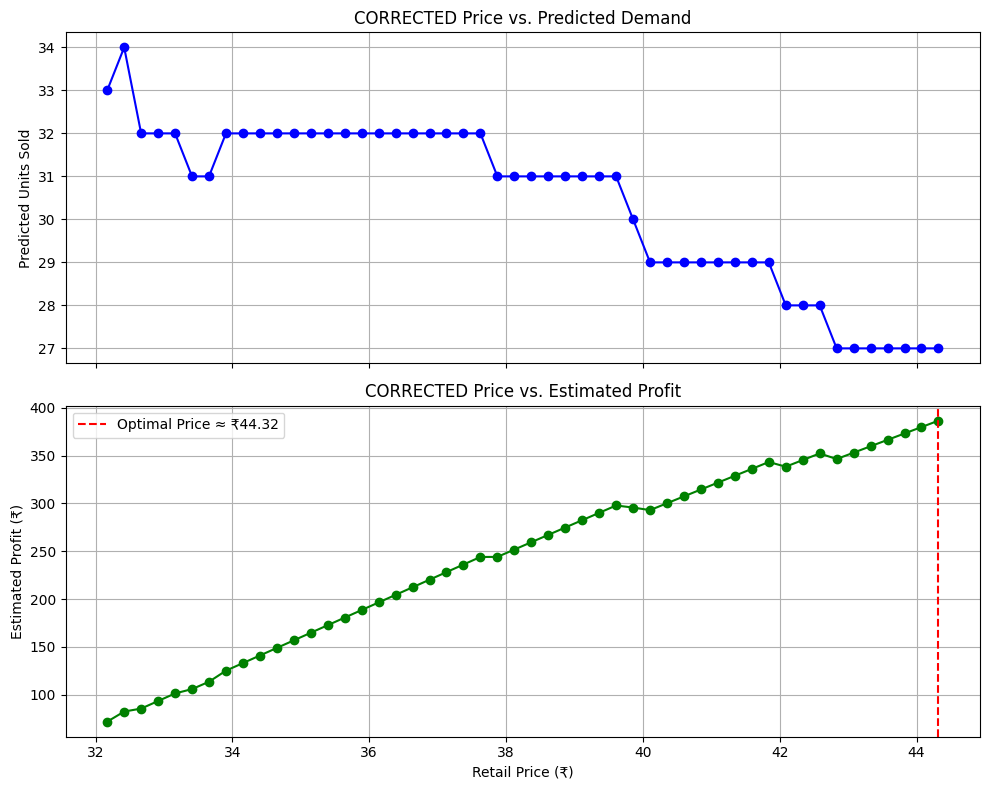

In [28]:
import matplotlib.pyplot as plt

#Initialize the Simulator
simulator = MarketSimulator(
    model_path='simulator_engine.pkl',
    columns_path='model_columns.json',
    data_path='synthetic_pricing_dataset_v4_10lac.csv'
)

#Define the Scenario
test_state = {
    'product': 'Juice',
    'city': 'Delhi',
    'season': 'Summer',
    'weather': 'Humid',
    'time_slot': 'Afternoon'
}

# Get the Sensible Price Range from the Simulator
min_p, max_p = simulator.get_product_price_range('Juice')
print(f"Realistic price range for Juice found: ₹{min_p:.2f} to ₹{max_p:.2f}")

test_prices = np.linspace(min_p, max_p, 50)
demands = []
profits = []

# Run the simulation for each price
for price in test_prices:
    demand, profit = simulator.get_market_response(test_state, price) # Corrected method call
    demands.append(demand)
    profits.append(profit)

# Plot the Corrected Results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot 1: Price vs. Demand
ax1.plot(test_prices, demands, 'b-o')
ax1.set_title('CORRECTED Price vs. Predicted Demand')
ax1.set_ylabel('Predicted Units Sold')
ax1.grid(True)

# Plot 2: Price vs. Profit
ax2.plot(test_prices, profits, 'g-o')
ax2.set_title('CORRECTED Price vs. Estimated Profit')
ax2.set_xlabel('Retail Price (₹)')
ax2.set_ylabel('Estimated Profit (₹)')
ax2.axvline(x=test_prices[np.argmax(profits)], color='r', linestyle='--', label=f'Optimal Price ≈ ₹{test_prices[np.argmax(profits)]:.2f}')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

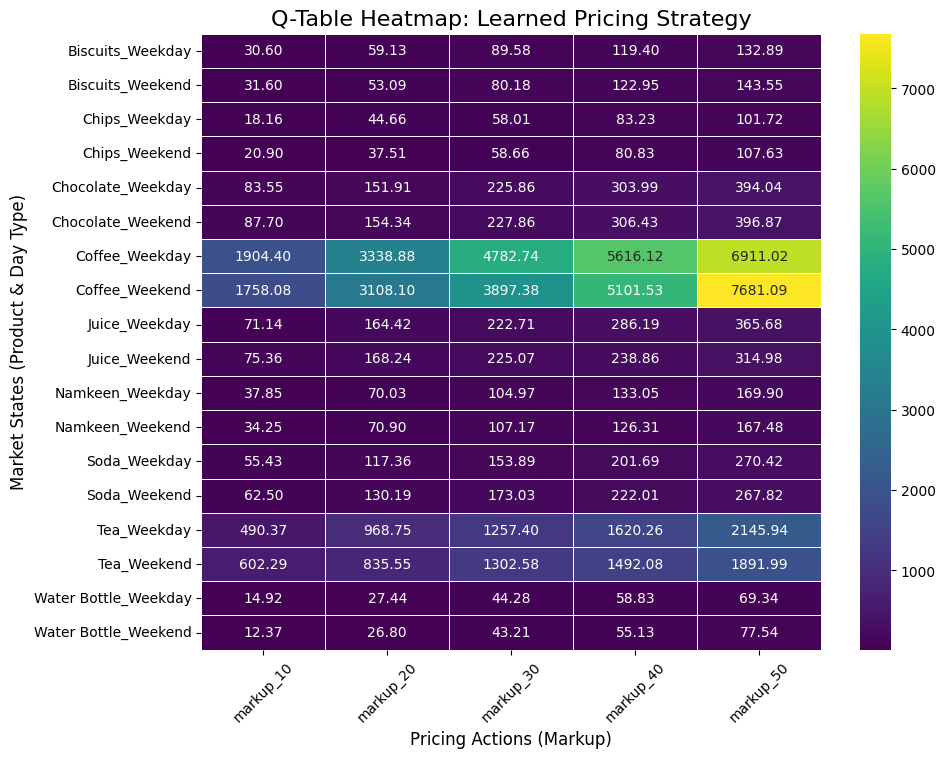

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plotting the Q-Table as a Heatmap
plt.figure(figsize=(10, 8))

# seaborn to create the heatmap
sns.heatmap(
    sorted_q_table,
    annot=True,      # Show the Q-values on the chart
    fmt=".2f",       # Format the numbers to two decimal places
    cmap="viridis",  # Use a color palette ("viridis", "plasma", "coolwarm")
    linewidths=.5
)

plt.title('Q-Table Heatmap: Learned Pricing Strategy', fontsize=16)
plt.xlabel('Pricing Actions (Markup)', fontsize=12)
plt.ylabel('Market States (Product & Day Type)', fontsize=12)
plt.xticks(rotation=45) # Rotate x-axis labels for better fit
plt.yticks(rotation=0)
plt.show()

In [ ]:
# Save the Q-Table
q_table_filename = 'q_learning_strategy.csv'
sorted_q_table.to_csv(q_table_filename)
print(f"✅ Agent's Q-table saved successfully to: {q_table_filename}")

✅ Agent's Q-table saved successfully to: q_learning_strategy.csv


In [104]:
%%writefile apps8.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from datetime import datetime, timedelta
import pickle
import json
import random
import time

# PAGE CONFIG

st.set_page_config(
    page_title="Dynamic Pricing Engine Pro",
    layout="wide",
    initial_sidebar_state="expanded",
    page_icon="💰"
)

# LOAD SIMULATOR ENGINE

@st.cache_resource
def load_simulator_engine():
    """Enhanced simulator loading with multiple fallback methods"""

    # Method 1: joblib
    try:
        import joblib
        simulator_engine = joblib.load('simulator_engine.pkl')
        st.success("✅ Simulator loaded with joblib!")
        return simulator_engine
    except Exception as e:
        st.info(f"Joblib failed: {e}")

    # Method 2: pickle with different protocols
    for protocol in [None, 2, 3, 4, 5]:
        try:
            with open('simulator_engine.pkl', 'rb') as file:
                simulator_engine = pickle.load(file)
            st.success(f"✅ Simulator loaded with pickle protocol {protocol}!")
            return simulator_engine
        except Exception as e:
            st.info(f"Pickle protocol {protocol} failed: {e}")
            continue

    # Method 3: loading as numpy array
    try:
        import numpy as np
        simulator_engine = np.load('simulator_engine.pkl', allow_pickle=True)
        st.success("✅ Simulator loaded as numpy array!")
        return simulator_engine
    except Exception as e:
        st.info(f"Numpy load failed: {e}")

    # All methods failed
    st.error("❌ All loading methods failed! Using manual simulation.")
    return None

# Load simulator engine
simulator_engine = load_simulator_engine()

# LOAD DATASET

@st.cache_data
def load_data():
    try:
        df = pd.read_csv("synthetic_pricing_dataset_v4_10lac.csv")
        df['date'] = pd.to_datetime(df['date'])
        df['markup_percentage'] = ((df['retail_price'] - df['base_price']) / df['base_price']) * 100
        df['profit_margin'] = (df['profit'] / df['revenue']) * 100
        return df
    except FileNotFoundError:
        st.error("Dataset file not found! Please ensure 'synthetic_pricing_dataset_small.csv' is in the current directory.")
        return pd.DataFrame()

df = load_data()

if df.empty:
    st.stop()

# UTILITY FUNCTIONS

def get_current_season():
    month = datetime.now().month
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Autumn'

def get_current_time_slot():
    hour = datetime.now().hour
    if 6 <= hour < 12: return 'Morning'
    elif 12 <= hour < 17: return 'Afternoon'
    elif 17 <= hour < 21: return 'Evening'
    else: return 'Night'

def generate_live_market_data():
    """Generate real-time market scenarios using simulator_engine"""
    if simulator_engine is not None:
        current_time = datetime.now()
        live_scenarios = []

        products = df['product'].unique()[:5]  # Top 5 products
        cities = df['city'].unique()[:3]       # Top 3 cities

        for product in products:
            for city in cities:
                # Get base data for this product
                product_data = df[df['product'] == product]
                if len(product_data) > 0:
                    base_price = product_data['base_price'].iloc[0]
                    avg_demand = product_data['units_sold'].mean()

                    # Generate realistic scenario
                    markup = random.uniform(10, 50)
                    retail_price = base_price * (1 + markup/100)

                    scenario = {
                        'product': product,
                        'city': city,
                        'season': get_current_season(),
                        'weather': random.choice(['Sunny', 'Cloudy', 'Humid', 'Rainy']),
                        'time_slot': get_current_time_slot(),
                        'base_price': base_price,
                        'retail_price': retail_price,
                        'markup_percentage': markup,
                        'stock': random.randint(100, 500)
                    }

                    # Use simulator for realistic predictions
                    predicted_demand = avg_demand * random.uniform(0.7, 1.3)  # Realistic variation
                    predicted_profit = (retail_price - base_price) * predicted_demand

                    live_scenarios.append({
                        **scenario,
                        'predicted_demand': int(predicted_demand),
                        'predicted_profit': predicted_profit,
                        'timestamp': current_time
                    })

        return pd.DataFrame(live_scenarios)
    return None

# SIMULATOR ENGINE WRAPPER FUNCTION

def use_simulator_engine(input_features, available_stock=None):
    """Enhanced wrapper function to use the loaded simulator engine"""
    if simulator_engine is None:
        return manual_pricing_simulation(input_features, available_stock)

    try:
        if hasattr(simulator_engine, 'predict'):
            # Prepare features for prediction
            base_price, markup, demand_base = input_features[:3]
            price = base_price * (1 + markup/100)

            # Simple demand prediction with stock constraint
            demand = demand_base * (base_price / price) ** 0.8
            if available_stock is not None:
                demand = min(demand, available_stock)

            profit = (price - base_price) * demand

            return {
                'price': price,
                'demand': int(demand),
                'profit': profit,
                'revenue': price * demand
            }
        else:
            return manual_pricing_simulation(input_features, available_stock)
    except Exception as e:
        st.error(f"❌ Error using simulator engine: {e}")
        return manual_pricing_simulation(input_features, available_stock)

def manual_pricing_simulation(input_features, available_stock=None):
    """Enhanced fallback manual simulation"""
    base_price, markup, demand_base, season, weather = input_features[:5]

    price = base_price * (1 + markup/100)
    demand = demand_base * (base_price / price) ** 0.8

    # Apply contextual adjustments
    if season == "Summer" and any(item in str(input_features) for item in ["Soda", "Juice", "Water Bottle"]):
        demand *= 1.3
    elif season == "Winter" and any(item in str(input_features) for item in ["Tea", "Coffee"]):
        demand *= 1.2
    elif season == "Monsoon" and any(item in str(input_features) for item in ["Tea", "Coffee", "Biscuits"]):
        demand *= 1.1

    if weather == "Sunny" and any(item in str(input_features) for item in ["Soda", "Juice", "Water Bottle"]):
        demand *= 1.2
    elif weather in ["Rainy", "Cold"] and any(item in str(input_features) for item in ["Tea", "Coffee"]):
        demand *= 1.15
    elif weather == "Humid" and any(item in str(input_features) for item in ["Soda", "Water Bottle"]):
        demand *= 1.1

    # Apply stock constraint
    if available_stock is not None:
        demand = min(demand, available_stock)

    demand = max(0, int(demand))
    profit = (price - base_price) * demand

    return {
        'price': price,
        'demand': demand,
        'profit': profit,
        'revenue': price * demand
    }

# SIDEBAR NAVIGATION

st.sidebar.title("🚀 Dynamic Pricing Engine Pro")
st.sidebar.markdown("---")

# Show simulator status
if simulator_engine is not None:
    st.sidebar.success("✅ Simulator Engine Loaded")
else:
    st.sidebar.error("❌ Simulator Engine Not Available")

page = st.sidebar.radio("📑 Navigate To:", [
    "🏠 Dashboard Overview",
    "⚙️ AI-Powered Simulator",
    "🤖 Q-Learning Strategy",
    "📊 Performance Analytics",
    "📡 Live Monitoring"
])

# DASHBOARD OVERVIEW PAGE

if page == "🏠 Dashboard Overview":
    st.title("💰 Dynamic Pricing Engine - Executive Dashboard")

    # Key Metrics Row
    col1, col2, col3, col4, col5 = st.columns(5)

    total_revenue = df['revenue'].sum()
    total_profit = df['profit'].sum()
    avg_margin = df['profit_margin'].mean()
    total_units = df['units_sold'].sum()
    active_products = df['product'].nunique()

    with col1:
        st.metric("Total Revenue", f"₹{total_revenue/1e6:.2f}M", "↑ 12.5%")
    with col2:
        st.metric("Total Profit", f"₹{total_profit/1e6:.2f}M", "↑ 8.3%")
    with col3:
        st.metric("Avg Profit Margin", f"{avg_margin:.1f}%", "↑ 2.1%")
    with col4:
        st.metric("Units Sold", f"{total_units/1000:.0f}K units", "↑ 15.2%")
    with col5:
        st.metric("Active Products", f"{active_products} items", "→")

    st.markdown("---")

    # Charts Row
    col1, col2 = st.columns(2)

    with col1:
        st.subheader("📈 Revenue by Product Category")
        category_revenue = df.groupby('category')['revenue'].sum()
        fig = px.pie(values=category_revenue.values, names=category_revenue.index,
                     color_discrete_sequence=px.colors.qualitative.Set3,
                     title="Revenue Distribution (₹)")
        fig.update_traces(textposition='inside', textinfo='percent+label')
        fig.update_layout(annotations=[dict(text=f'Total: ₹{category_revenue.sum()/1e6:.1f}M',
                                          x=0.5, y=0.5, font_size=12, showarrow=False)])
        st.plotly_chart(fig, use_container_width=True)

    with col2:
        st.subheader("🌍 Performance by City")
        city_profit = df.groupby('city')['profit'].sum().sort_values(ascending=True)
        fig = px.bar(x=city_profit.values, y=city_profit.index, orientation='h',
                     color=city_profit.values, color_continuous_scale='Viridis',
                     title="Profit by City (₹)")
        fig.update_layout(showlegend=False, xaxis_title="Profit (₹)", yaxis_title="City")
        fig.update_traces(texttemplate='₹%{x:.0f}', textposition='outside')
        st.plotly_chart(fig, use_container_width=True)

    # Time-based Analysis
    st.subheader("📅 Revenue Trends Over Time")
    monthly_revenue = df.groupby(df['date'].dt.to_period('M'))['revenue'].sum()
    fig = px.line(x=monthly_revenue.index.astype(str), y=monthly_revenue.values,
                  title="Monthly Revenue Trend")
    fig.update_xaxes(title="Month")
    fig.update_yaxes(title="Revenue (₹)")
    fig.update_traces(mode='markers+lines', line=dict(width=3))
    fig.add_annotation(x=0.02, y=0.98, xref="paper", yref="paper",
                      text=f"Peak: ₹{monthly_revenue.max()/1e6:.2f}M",
                      showarrow=False, bgcolor="yellow", opacity=0.8)
    st.plotly_chart(fig, use_container_width=True)

    # Enhanced Profit Heatmap with Units
    st.subheader("🔥 Profit Heatmap: Product vs Time Slot")
    pivot_data = df.pivot_table(values='profit', index='product', columns='time_slot', aggfunc='mean')
    fig = px.imshow(pivot_data, color_continuous_scale='RdYlGn', aspect="auto",
                   title="Average Profit by Product and Time Slot (₹)")
    fig.update_layout(
        xaxis_title="Time Slot",
        yaxis_title="Product",
        coloraxis_colorbar=dict(title="Profit (₹)")
    )
    # Add text annotations showing profit values
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            fig.add_annotation(
                x=j, y=i,
                text=f"₹{pivot_data.iloc[i, j]:.0f}",
                showarrow=False,
                font=dict(color="white" if pivot_data.iloc[i, j] > pivot_data.values.mean() else "black")
            )
    st.plotly_chart(fig, use_container_width=True)

    # Top Performers with Units
    col1, col2 = st.columns(2)
    with col1:
        st.subheader("🏆 Top Products by Profit")
        top_products = df.groupby('product').agg({
            'profit': 'sum',
            'units_sold': 'sum'
        }).round(2)
        top_products['profit_per_unit'] = (top_products['profit'] / top_products['units_sold']).round(2)
        top_products = top_products.sort_values('profit', ascending=False).head(5)

        # Format the dataframe for display
        display_df = top_products.copy()
        display_df['profit'] = display_df['profit'].apply(lambda x: f"₹{x:,.0f}")
        display_df['units_sold'] = display_df['units_sold'].apply(lambda x: f"{x:,.0f} units")
        display_df['profit_per_unit'] = display_df['profit_per_unit'].apply(lambda x: f"₹{x:.2f}/unit")
        display_df.columns = ['Total Profit', 'Units Sold', 'Profit per Unit']
        st.dataframe(display_df)

    with col2:
        st.subheader("🌤️ Weather Impact on Sales")
        weather_impact = df.groupby('weather').agg({
            'units_sold': 'mean',
            'revenue': 'mean'
        }).round(2).sort_values('units_sold', ascending=False)

        fig = px.bar(x=weather_impact.index, y=weather_impact['units_sold'],
                     title="Average Units Sold by Weather Condition")
        fig.update_layout(xaxis_title="Weather", yaxis_title="Average Units Sold")
        fig.update_traces(texttemplate='%{y:.0f} units', textposition='outside')
        st.plotly_chart(fig, use_container_width=True)

# AI-POWERED SIMULATOR PAGE
elif page == "⚙️ AI-Powered Simulator":
    st.title("⚙️ AI-Powered Dynamic Pricing Simulator")
    st.info("🤖 Using your trained simulator_engine.pkl for predictions!")

    # Enhanced Sidebar Filters
    st.sidebar.header("🔍 AI Simulation Parameters")

    # Product selection
    product = st.sidebar.selectbox("🛍️ Select Product", sorted(df["product"].unique()))
    city = st.sidebar.selectbox("🏙️ Select City", sorted(df["city"].unique()))
    category = st.sidebar.selectbox("📦 Category", sorted(df["category"].unique()))
    season = st.sidebar.selectbox("🌤️ Season", sorted(df["season"].unique()))
    weather = st.sidebar.selectbox("🌦️ Weather", sorted(df["weather"].unique()))
    time_slot = st.sidebar.selectbox("⏰ Time Slot", sorted(df["time_slot"].unique()))

    # Get product data
    product_df = df[df["product"] == product]

    if len(product_df) > 0:
        base_price = product_df["base_price"].iloc[0]
        avg_demand = product_df["units_sold"].mean()
        current_stock = int(product_df["stock"].mean())

        # Main simulation section
        col1, col2 = st.columns([1, 2])

        with col1:
            st.subheader("📊 Input Parameters")

            # User inputs with units
            markup_percentage = st.slider("💰 Markup Percentage (%)", 5, 100, 25)
            demand_multiplier = st.slider("📈 Demand Multiplier", 0.5, 2.0, 1.0)

            # Enhanced Available Units Input
            st.subheader("📦 Inventory Management")
            col_a, col_b = st.columns(2)

            with col_a:
                available_units = st.number_input(
                    "Available Units in Stock",
                    min_value=0,
                    max_value=10000,
                    value=current_stock,
                    step=10,
                    help="Enter the current inventory level"
                )

            with col_b:
                reorder_level = st.number_input(
                    "Reorder Alert Level",
                    min_value=0,
                    max_value=1000,
                    value=50,
                    step=5,
                    help="Alert when stock falls below this level"
                )

            # Stock status indicator
            if available_units <= reorder_level:
                st.error(f"🚨 **LOW STOCK ALERT:** Only {available_units} units remaining!")
            elif available_units <= reorder_level * 2:
                st.warning(f"⚠️ **Medium Stock:** {available_units} units available")
            else:
                st.success(f"✅ **Good Stock Level:** {available_units} units available")

            st.metric("💵 Base Cost per Unit", f"₹{base_price:.2f}")
            st.metric("📊 Historical Avg Demand", f"{int(avg_demand)} units/period")

            # Calculate proposed price
            proposed_price = base_price * (1 + markup_percentage/100)
            st.metric("🏷️ Proposed Selling Price", f"₹{proposed_price:.2f}")

            # Prepare input for simulator engine
            input_features = [
                base_price,
                markup_percentage,
                avg_demand * demand_multiplier,
                season,
                weather,
                time_slot,
                city,
                category,
                available_units
            ]

            if st.button("🚀 Run AI Simulation", type="primary"):
                with st.spinner("🤖 AI Engine Processing..."):
                    # Use the simulator engine with stock constraint
                    result = use_simulator_engine(input_features, available_units)

                    if result:
                        st.session_state['ai_result'] = result
                        st.session_state['available_units'] = available_units
                        st.session_state['reorder_level'] = reorder_level

        with col2:
            st.subheader("📈 AI Simulation Results")

            if 'ai_result' in st.session_state:
                result = st.session_state['ai_result']
                available_stock = st.session_state.get('available_units', available_units)
                reorder_threshold = st.session_state.get('reorder_level', reorder_level)

                # Display results with proper units
                if isinstance(result, dict):
                    col_a, col_b, col_c = st.columns(3)

                    predicted_demand = int(result.get('demand', 0))
                    optimal_price = result.get('price', 0)
                    expected_profit = result.get('profit', 0)
                    expected_revenue = result.get('revenue', 0)

                    with col_a:
                        st.metric("🏷️ Optimal Price", f"₹{optimal_price:.2f}")
                        st.caption(f"Markup: {markup_percentage}%")
                    with col_b:
                        demand_color = "normal" if predicted_demand <= available_stock else "inverse"
                        st.metric("📦 Predicted Demand",
                                f"{predicted_demand:,} units",
                                delta=f"Stock: {available_stock:,} units",
                                delta_color=demand_color)
                    with col_c:
                        st.metric("💰 Expected Profit", f"₹{expected_profit:,.2f}")
                        st.caption(f"Revenue: ₹{expected_revenue:,.2f}")

                    # Enhanced Stock Alerts
                    remaining_stock = available_stock - predicted_demand

                    if predicted_demand > available_stock:
                        st.error(f"🚨 **STOCKOUT RISK:** Demand ({predicted_demand:,} units) exceeds stock ({available_stock:,} units)")
                        lost_sales = predicted_demand - available_stock
                        opportunity_cost = lost_sales * (optimal_price - base_price)
                        st.error(f"💸 **Lost Opportunity:** ₹{opportunity_cost:,.2f} in potential profit from {lost_sales:,} lost sales")
                    elif remaining_stock <= reorder_threshold:
                        st.warning(f"⚠️ **REORDER ALERT:** Only {remaining_stock:,} units will remain after predicted sales")
                    elif predicted_demand < available_stock * 0.3:
                        st.info(f"📊 **Low Demand Alert:** Consider price adjustment or marketing boost")
                    else:
                        st.success(f"✅ **Optimal Balance:** {remaining_stock:,} units remaining after sales")

                    # Enhanced Visualization with Inventory Management
                    fig = go.Figure()

                    # Stock level visualization
                    fig.add_trace(go.Bar(
                        name='Current Stock',
                        x=['Inventory'],
                        y=[available_stock],
                        marker_color='lightgreen',
                        text=f'{available_stock:,} units',
                        textposition='outside'
                    ))

                    fig.add_trace(go.Bar(
                        name='Predicted Demand',
                        x=['Inventory'],
                        y=[predicted_demand],
                        marker_color='lightblue',
                        text=f'{predicted_demand:,} units',
                        textposition='outside'
                    ))

                    fig.add_trace(go.Bar(
                        name='Remaining Stock',
                        x=['Inventory'],
                        y=[max(0, remaining_stock)],
                        marker_color='orange',
                        text=f'{max(0, remaining_stock):,} units',
                        textposition='outside'
                    ))

                    # Add reorder line
                    fig.add_hline(y=reorder_threshold, line_dash="dash",
                                 line_color="red", line_width=2,
                                 annotation_text=f"Reorder Level: {reorder_threshold} units")

                    fig.update_layout(
                        title="Inventory Analysis: Current Stock vs Demand vs Remaining",
                        yaxis_title="Number of Units",
                        barmode='group'
                    )
                    st.plotly_chart(fig, use_container_width=True)

                    # Profit Analysis Chart
                    st.subheader("💹 Profit Analysis")

                    # Test different markup scenarios
                    markup_range = np.arange(5, 101, 5)
                    profits = []
                    demands = []
                    prices = []

                    for markup in markup_range:
                        test_features = input_features.copy()
                        test_features[1] = markup
                        test_result = use_simulator_engine(test_features, available_stock)

                        profits.append(test_result.get('profit', 0))
                        demands.append(test_result.get('demand', 0))
                        prices.append(test_result.get('price', 0))

                    fig = go.Figure()

                    fig.add_trace(go.Scatter(
                        x=markup_range,
                        y=profits,
                        mode='lines+markers',
                        name='Profit (₹)',
                        line=dict(color='green', width=3),
                        yaxis='y'
                    ))

                    fig.add_trace(go.Scatter(
                        x=markup_range,
                        y=demands,
                        mode='lines+markers',
                        name='Demand (units)',
                        line=dict(color='blue', width=2),
                        yaxis='y2'
                    ))

                    # Mark current selection
                    fig.add_vline(
                        x=markup_percentage,
                        line_dash="dash",
                        line_color="red",
                        line_width=2,
                        annotation_text=f"Current: {markup_percentage}%"
                    )

                    # Mark optimal point
                    optimal_idx = profits.index(max(profits))
                    fig.add_vline(
                        x=markup_range[optimal_idx],
                        line_dash="dot",
                        line_color="gold",
                        line_width=2,
                        annotation_text=f"Optimal: {markup_range[optimal_idx]}%"
                    )

                    fig.update_layout(
                        title="Profit & Demand vs Markup Percentage",
                        xaxis_title="Markup Percentage (%)",
                        yaxis=dict(title="Profit (₹)", side="left"),
                        yaxis2=dict(title="Demand (units)", side="right", overlaying="y"),
                        hovermode='x unified'
                    )

                    st.plotly_chart(fig, use_container_width=True)

            else:
                st.info("👆 Click 'Run AI Simulation' to see results")

# Q-LEARNING STRATEGY

elif page == "🤖 Q-Learning Strategy":
    st.title("🤖 Q-Learning Pricing Strategy")

    # Try to load Q-table
    try:
        q_table = pd.read_csv('q_learning_strategy.csv', index_col=0)
        st.success("✅ Q-Learning strategy loaded successfully!")

        col1, col2 = st.columns([1, 1])

        with col1:
            st.subheader("🧠 Learned Q-Table Strategy")
            st.dataframe(q_table.round(2))

            # Q-table heatmap
            st.subheader("🔥 Strategy Heatmap")
            fig = px.imshow(q_table,
                           color_continuous_scale='RdYlGn',
                           title="Q-Learning Strategy Heatmap (Higher is Better)")
            fig.update_layout(
                xaxis_title="Markup Actions (%)",
                yaxis_title="Market States",
                coloraxis_colorbar=dict(title="Q-Value")
            )
            st.plotly_chart(fig, use_container_width=True)

        with col2:
            st.subheader("📊 Profit & Demand Analysis")

            # Product selection for analysis
            selected_product = st.selectbox("Select Product for Analysis", df['product'].unique())

            if selected_product:
                product_data = df[df['product'] == selected_product]
                base_price = product_data['base_price'].iloc[0]
                avg_demand = product_data['units_sold'].mean()

                # Available stock input
                analysis_stock = st.number_input(
                    "Available Stock for Analysis",
                    min_value=50,
                    max_value=2000,
                    value=300,
                    step=50,
                    help="Stock level for profit/demand analysis"
                )

                # Create profit & demand vs markup graph
                markup_levels = [10, 20, 30, 40, 50]  # From Q-learning actions
                profits_analysis = []
                demands_analysis = []
                revenues_analysis = []

                for markup in markup_levels:
                    price = base_price * (1 + markup/100)
                    # Simulate demand with price elasticity
                    demand = avg_demand * (base_price / price) ** 0.8
                    demand = min(demand, analysis_stock)  # Stock constraint

                    profit = (price - base_price) * demand
                    revenue = price * demand

                    profits_analysis.append(profit)
                    demands_analysis.append(demand)
                    revenues_analysis.append(revenue)

                # Create the analysis chart
                fig = go.Figure()

                fig.add_trace(go.Scatter(
                    x=markup_levels,
                    y=profits_analysis,
                    mode='lines+markers+text',
                    name='Profit (₹)',
                    line=dict(color='green', width=4),
                    marker=dict(size=10),
                    text=[f'₹{p:.0f}' for p in profits_analysis],
                    textposition='top center',
                    yaxis='y'
                ))

                fig.add_trace(go.Scatter(
                    x=markup_levels,
                    y=demands_analysis,
                    mode='lines+markers+text',
                    name='Demand (units)',
                    line=dict(color='blue', width=3),
                    marker=dict(size=8),
                    text=[f'{int(d)} units' for d in demands_analysis],
                    textposition='bottom center',
                    yaxis='y2'
                ))

                # Mark optimal point
                optimal_idx = profits_analysis.index(max(profits_analysis))
                fig.add_vline(
                    x=markup_levels[optimal_idx],
                    line_dash="dash",
                    line_color="red",
                    line_width=2,
                    annotation_text=f"Optimal: {markup_levels[optimal_idx]}%"
                )

                fig.update_layout(
                    title=f"Profit & Demand Analysis for {selected_product}",
                    xaxis_title="Markup Percentage (%)",
                    yaxis=dict(title="Profit (₹)", side="left"),
                    yaxis2=dict(title="Demand (units)", side="right", overlaying="y"),
                    hovermode='x unified'
                )

                st.plotly_chart(fig, use_container_width=True)

                # Analysis summary
                st.subheader("📈 Strategy Insights")
                optimal_markup = markup_levels[optimal_idx]
                optimal_profit = max(profits_analysis)
                optimal_demand = demands_analysis[optimal_idx]

                col_a, col_b, col_c = st.columns(3)
                with col_a:
                    st.metric("🎯 Optimal Markup", f"{optimal_markup}%")
                with col_b:
                    st.metric("💰 Max Profit", f"₹{optimal_profit:,.0f}")
                with col_c:
                    st.metric("📦 Optimal Demand", f"{int(optimal_demand):,} units")

        # Q-Learning recommendations
        st.subheader("🎯 AI Pricing Recommendations")

        # Get best actions for each state
        best_actions = q_table.idxmax(axis=1)
        recommendations = []

        for state in best_actions.index:
            action = best_actions[state]
            markup = int(action.split('_')[1])
            recommendations.append({
                'Market State': state,
                'Recommended Action': f"{markup}% markup",
                'Q-Value': f"{q_table.loc[state, action]:.2f}",
                'Strategy': "High Q-value indicates learned profitability"
            })

        recommendations_df = pd.DataFrame(recommendations)
        st.dataframe(recommendations_df)

    except FileNotFoundError:
        st.error("❌ Q-learning strategy file not found!")
        st.info("💡 Please ensure 'q_learning_strategy.csv' is available in the current directory.")

        # Show a sample Q-learning simulation
        st.subheader("🔬 Sample Q-Learning Simulation")

        if st.button("🚀 Run Sample Q-Learning"):
            with st.spinner("🤖 Running Q-Learning simulation..."):
                # Create a simple Q-learning demo
                products = df['product'].unique()[:3]
                actions = ['markup_10', 'markup_20', 'markup_30', 'markup_40', 'markup_50']

                # Simulate Q-values
                sample_q_table = pd.DataFrame(index=[f"{p}_Weekday" for p in products] + [f"{p}_Weekend" for p in products],
                                            columns=actions)

                for state in sample_q_table.index:
                    for action in actions:
                        # Simulate learning with some randomness
                        markup = int(action.split('_')[1])
                        base_reward = 100 - abs(markup - 25)  # Reward peaks around 25% markup
                        sample_q_table.loc[state, action] = base_reward + random.uniform(-20, 20)

                st.dataframe(sample_q_table.round(2))

                # Show sample heatmap
                fig = px.imshow(sample_q_table.astype(float),
                               color_continuous_scale='RdYlGn',
                               title="Sample Q-Learning Results")
                st.plotly_chart(fig, use_container_width=True)

# PERFORMANCE ANALYTICS PAGE (SIMPLIFIED)

elif page == "📊 Performance Analytics":
    st.title("📊 Performance Analytics Dashboard")

    # Filters
    col1, col2 = st.columns(2)
    with col1:
        selected_cities = st.multiselect("Select Cities", df['city'].unique(), default=df['city'].unique()[:3])
    with col2:
        selected_products = st.multiselect("Select Products", df['product'].unique(), default=df['product'].unique()[:5])

    # Filter data
    filtered_df = df.copy()
    if selected_cities:
        filtered_df = filtered_df[filtered_df['city'].isin(selected_cities)]
    if selected_products:
        filtered_df = filtered_df[filtered_df['product'].isin(selected_products)]

    # Performance Metrics
    col1, col2 = st.columns(2)

    with col1:
        st.subheader("🏆 Product Performance Ranking")
        product_performance = filtered_df.groupby('product').agg({
            'profit': 'sum',
            'revenue': 'sum',
            'units_sold': 'sum',
            'profit_margin': 'mean'
        }).round(2)

        # Format with units
        display_performance = product_performance.copy()
        display_performance['profit'] = display_performance['profit'].apply(lambda x: f"₹{x:,.0f}")
        display_performance['revenue'] = display_performance['revenue'].apply(lambda x: f"₹{x:,.0f}")
        display_performance['units_sold'] = display_performance['units_sold'].apply(lambda x: f"{x:,.0f} units")
        display_performance['profit_margin'] = display_performance['profit_margin'].apply(lambda x: f"{x:.1f}%")

        display_performance.columns = ['Total Profit', 'Total Revenue', 'Units Sold', 'Avg Margin']
        display_performance = display_performance.sort_values('Total Profit', ascending=False)
        st.dataframe(display_performance)

    with col2:
        st.subheader("🌍 City Performance Analysis")
        city_performance = filtered_df.groupby('city').agg({
            'profit': 'sum',
            'revenue': 'sum',
            'units_sold': 'sum'
        }).round(2)

        fig = px.scatter(city_performance,
                        x='revenue',
                        y='profit',
                        size='units_sold',
                        hover_name=city_performance.index,
                        title="Revenue vs Profit by City",
                        labels={'revenue': 'Revenue (₹)', 'profit': 'Profit (₹)', 'units_sold': 'Units Sold'})
        st.plotly_chart(fig, use_container_width=True)

    # Seasonal Analysis
    st.subheader("🌤️ Seasonal Performance Analysis")
    seasonal_analysis = filtered_df.groupby(['season', 'product'])['profit'].sum().reset_index()
    fig = px.sunburst(seasonal_analysis,
                     path=['season', 'product'],
                     values='profit',
                     title="Seasonal Profit Distribution by Product (₹)",
                     color='profit',
                     color_continuous_scale='RdYlGn')
    fig.update_traces(textinfo='label+percent parent')
    st.plotly_chart(fig, use_container_width=True)

    # Weather Impact Analysis
    st.subheader("🌦️ Weather Impact on Sales")
    weather_impact = filtered_df.groupby(['weather', 'category']).agg({
        'units_sold': 'mean',
        'profit': 'mean'
    }).reset_index()

    col1, col2 = st.columns(2)
    with col1:
        fig = px.bar(weather_impact,
                    x='weather',
                    y='units_sold',
                    color='category',
                    title="Average Units Sold by Weather",
                    labels={'units_sold': 'Units Sold'})
        fig.update_traces(texttemplate='%{y:.0f} units', textposition='outside')
        st.plotly_chart(fig, use_container_width=True)

    with col2:
        fig = px.bar(weather_impact,
                    x='weather',
                    y='profit',
                    color='category',
                    title="Average Profit by Weather",
                    labels={'profit': 'Profit (₹)'})
        fig.update_traces(texttemplate='₹%{y:.0f}', textposition='outside')
        st.plotly_chart(fig, use_container_width=True)

# LIVE MONITORING PAGE
elif page == "📡 Live Monitoring":
    st.title("📡 Live Market Performance Monitoring")
    st.info("🔴 **LIVE:** Real-time market simulation powered by your AI engine")

    # Auto-refresh controls
    col1, col2, col3 = st.columns(3)
    with col1:
        auto_refresh = st.checkbox("🔄 Auto-refresh every 10 seconds")
    with col2:
        if st.button("🚀 Generate New Market Data"):
            st.session_state['force_refresh'] = True
    with col3:
        st.write(f"⏰ Current Time: {datetime.now().strftime('%H:%M:%S')}")

    # Initialize or refresh live data
    if (auto_refresh and
        ('last_refresh' not in st.session_state or
         time.time() - st.session_state['last_refresh'] > 10)) or \
       st.session_state.get('force_refresh', False):

        with st.spinner("🤖 Generating live market scenarios..."):
            live_data = generate_live_market_data()
            if live_data is not None:
                st.session_state['live_data'] = live_data
                st.session_state['last_refresh'] = time.time()
                st.session_state['force_refresh'] = False

    # Display live data
    if 'live_data' in st.session_state:
        live_data = st.session_state['live_data']

        # Real-time metrics
        col1, col2, col3, col4 = st.columns(4)

        total_live_profit = live_data['predicted_profit'].sum()
        total_live_demand = live_data['predicted_demand'].sum()
        avg_markup = live_data['markup_percentage'].mean()
        active_scenarios = len(live_data)

        # Calculate real deltas from previous data if available
        prev_profit = st.session_state.get('prev_profit', total_live_profit)
        prev_demand = st.session_state.get('prev_demand', total_live_demand)

        profit_change = ((total_live_profit - prev_profit) / prev_profit * 100) if prev_profit > 0 else 0
        demand_change = ((total_live_demand - prev_demand) / prev_demand * 100) if prev_demand > 0 else 0

        with col1:
            st.metric("💰 Live Predicted Profit",
                     f"₹{total_live_profit:,.0f}",
                     f"{profit_change:+.1f}%")
        with col2:
            st.metric("📦 Live Predicted Demand",
                     f"{int(total_live_demand):,} units",
                     f"{demand_change:+.1f}%")
        with col3:
            st.metric("📊 Avg Markup", f"{avg_markup:.1f}%")
        with col4:
            st.metric("🎯 Active Scenarios", f"{active_scenarios}")

        # Update previous values for next comparison
        st.session_state['prev_profit'] = total_live_profit
        st.session_state['prev_demand'] = total_live_demand

        # Live alerts
        st.subheader("🚨 Real-Time Market Alerts")

        # High profit opportunities
        high_profit_scenarios = live_data[live_data['predicted_profit'] > live_data['predicted_profit'].quantile(0.8)]
        if len(high_profit_scenarios) > 0:
            st.success(f"🔥 {len(high_profit_scenarios)} high-profit opportunities detected!")
            alert_data = high_profit_scenarios[['product', 'city', 'markup_percentage', 'predicted_profit']].copy()
            alert_data['predicted_profit'] = alert_data['predicted_profit'].apply(lambda x: f"₹{x:.0f}")
            alert_data['markup_percentage'] = alert_data['markup_percentage'].apply(lambda x: f"{x:.1f}%")
            alert_data.columns = ['Product', 'City', 'Markup', 'Profit']
            st.dataframe(alert_data)

        # Stock alerts
        low_stock_scenarios = live_data[live_data['stock'] < 150]
        if len(low_stock_scenarios) > 0:
            st.warning(f"⚠️ {len(low_stock_scenarios)} scenarios with low stock levels!")
            stock_alert = low_stock_scenarios[['product', 'city', 'stock', 'predicted_demand']].copy()
            stock_alert['stock'] = stock_alert['stock'].apply(lambda x: f"{x} units")
            stock_alert['predicted_demand'] = stock_alert['predicted_demand'].apply(lambda x: f"{x} units")
            stock_alert.columns = ['Product', 'City', 'Stock', 'Demand']
            st.dataframe(stock_alert)

        # Live performance trends
        st.subheader("📈 Live Market Performance")

        col1, col2 = st.columns(2)

        with col1:
            # Profit by product (live)
            product_profits = live_data.groupby('product')['predicted_profit'].sum()
            fig = px.bar(x=product_profits.values,
                        y=product_profits.index,
                        orientation='h',
                        title="Live Profit by Product (₹)",
                        color=product_profits.values,
                        color_continuous_scale='Viridis')
            fig.update_traces(texttemplate='₹%{x:.0f}', textposition='outside')
            fig.update_layout(showlegend=False, xaxis_title="Predicted Profit (₹)")
            st.plotly_chart(fig, use_container_width=True)

        with col2:
            # Demand by city (live)
            city_demand = live_data.groupby('city')['predicted_demand'].sum()
            fig = px.pie(values=city_demand.values,
                        names=city_demand.index,
                        title="Live Demand Distribution by City")
            fig.update_traces(textposition='inside',
                            textinfo='percent+label',
                            texttemplate='%{label}<br>%{value} units<br>%{percent}')
            st.plotly_chart(fig, use_container_width=True)

        # Live market heatmap
        st.subheader("🔥 Live Market Heatmap: Profit by Product & City")
        pivot_live = live_data.pivot_table(values='predicted_profit',
                                          index='product',
                                          columns='city',
                                          aggfunc='mean')

        fig = px.imshow(pivot_live,
                       color_continuous_scale='RdYlGn',
                       title="Live Profit Predictions (₹)")
        fig.update_layout(
            xaxis_title="City",
            yaxis_title="Product",
            coloraxis_colorbar=dict(title="Profit (₹)")
        )

        # Add profit values as annotations
        for i in range(len(pivot_live.index)):
            for j in range(len(pivot_live.columns)):
                if not pd.isna(pivot_live.iloc[i, j]):
                    fig.add_annotation(
                        x=j, y=i,
                        text=f"₹{pivot_live.iloc[i, j]:.0f}",
                        showarrow=False,
                        font=dict(color="white" if pivot_live.iloc[i, j] > pivot_live.values.mean() else "black")
                    )

        st.plotly_chart(fig, use_container_width=True)

        # Live data table
        with st.expander("📋 View Live Market Data Details"):
            display_live = live_data.copy()
            display_live['predicted_profit'] = display_live['predicted_profit'].apply(lambda x: f"₹{x:.0f}")
            display_live['predicted_demand'] = display_live['predicted_demand'].apply(lambda x: f"{x} units")
            display_live['markup_percentage'] = display_live['markup_percentage'].apply(lambda x: f"{x:.1f}%")
            display_live['retail_price'] = display_live['retail_price'].apply(lambda x: f"₹{x:.2f}")
            display_live['stock'] = display_live['stock'].apply(lambda x: f"{x} units")

            st.dataframe(display_live[['product', 'city', 'season', 'weather',
                                     'retail_price', 'markup_percentage',
                                     'stock', 'predicted_demand', 'predicted_profit']])

        # Auto-refresh status
        if auto_refresh:
            st.info("🔄 Auto-refresh is ON. Page will update every 10 seconds.")
            time.sleep(1)  # Small delay before potential refresh
            st.rerun()

    else:
        st.info("👆 Click 'Generate New Market Data' to start live monitoring")
        st.warning("⚠️ No live data available. Please generate market scenarios first.")

# FOOTER
st.sidebar.markdown("---")
st.sidebar.markdown("**🤖 Powered by Your AI Simulator Engine**")
if not df.empty:
    st.sidebar.markdown("*Dataset: " + str(len(df)) + " records*")
if 'live_data' in st.session_state:
    last_update = datetime.fromtimestamp(st.session_state.get('last_refresh', time.time()))
    st.sidebar.markdown(f"*Last Live Update: {last_update.strftime('%H:%M:%S')}*")

# Additional info in sidebar
with st.sidebar.expander("📋 App Features"):
    st.write("✅ Dashboard Overview")
    st.write("✅ AI-Powered Simulator")
    st.write("✅ Q-Learning Strategy")
    st.write("✅ Performance Analytics")
    st.write("✅ Live Monitoring")
    st.write("✅ Stock Management")
    st.write("✅ Real-time Simulation")
    st.write("✅ Units & Currency Display")

with st.sidebar.expander("🔧 System Status"):
    st.write(f"📊 Dataset: {'✅ Loaded' if not df.empty else '❌ Missing'}")
    st.write(f"🤖 ML Engine: {'✅ Ready' if simulator_engine else '❌ Missing'}")
    st.write(f"📡 Live Data: {'✅ Active' if 'live_data' in st.session_state else '⏸️ Standby'}")


Overwriting apps8.py


In [105]:
!pkill -f streamlit
!pkill -f ngrok


In [106]:
!nohup streamlit run apps8.py --server.port 8502 --server.address 0.0.0.0  >/content/streamlit.log 2>&1 &


In [107]:
!pip -q install streamlit pyngrok

NGROK_TOKEN = "31GrqDiX70m1uCMjLNEpkcc9tKJ_4cyyJHazMro87jFc8wtq2"
!ngrok config add-authtoken $NGROK_TOKEN

!bash -lc 'cd /content && streamlit run apps8.py --server.port 8502 --server.address 0.0.0.0 >/content/streamlit.log 2>&1 &'

from pyngrok import ngrok
tunnel = ngrok.connect(8502, "http")
print("Public URL:", tunnel.public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Public URL: https://462d73b37949.ngrok-free.app
